In [1291]:
from pharynx_analysis import (
    pharynx_io as pio, 
    image_processing as ip, 
    experiment, 
    plots, 
    profile_processing,
    data_analysis as da
)

import xarray as xr
from pathlib import Path
from tqdm import tqdm_notebook
from scipy import ndimage as ndi
from scipy import interpolate
import seaborn as sns
from importlib import reload
import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.backends.backend_pdf import PdfPages

reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)
reload(da)

pd.set_option('display.max_rows', 100)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

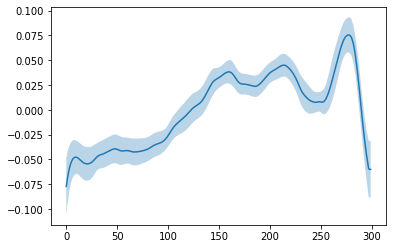

In [1295]:
bbb = xr.load_dataarray('/Users/sean/code/wormAnalysis/data/paired_ratio/2017_08_23-HD233_4mm_lev/analyses/2019-08-29_skfda_reg/2017_08_23-HD233_4mm_lev-profile_data.nc')

plots.plot_profile_avg_with_bounds(bbb.sel(wavelength='r', pair=0) - bbb.sel(wavelength='r', pair=0).mean(dim='position'))

In [5]:
ex = experiment.PairExperiment(
    experiment_dir  = Path("/Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47"),
    imaging_scheme  = "TL/470/410/470/410",
    should_register = False
)
ex.full_pipeline()

11:35:07 INFO:Starting full pipeline run for /Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47
11:35:07 INFO:Loading Images
11:35:08 INFO:Segmenting pharynxes
11:35:09 INFO:Centering and rotating pharynxes
100%|██████████| 123/123 [00:08<00:00, 14.26it/s]
11:35:19 INFO:Calculating midlines
100%|██████████| 123/123 [00:01<00:00, 113.60it/s]
11:35:20 INFO:Measuring under midlines
100%|██████████| 123/123 [00:01<00:00, 113.66it/s]
11:35:21 INFO:Trimming intensity data
11:35:22 INFO:Calculating redox measurements
11:35:22 INFO:Saving 2017_02_22-HD233_SAY47 inside /Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47
11:35:22 INFO:Saving region means to /Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-08-27_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-summary_table.csv
11:35:22 INFO:Saving profile data to /Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-08-27_fra

In [1039]:
reload(profile_processing);
i = i + 1
untrimmed_i = ex.untrimmed_profiles[0]
reg_data = profile_processing.register_profiles(untrimmed_i, warp_lam=1e-1)

In [983]:
%timeit -n2 profile_processing.register_profiles(untrimmed_i, warp_lam=1e-1, smooth_nbasis=30, rough_nbasis=200)

15 s ± 778 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [984]:
%timeit -n2 profile_processing.register_profiles(untrimmed_i, warp_lam=1e-1, smooth_nbasis=64, rough_nbasis=200)

16.1 s ± 616 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [985]:
%timeit -n2 profile_processing.register_profiles(untrimmed_i, warp_lam=1e-1, smooth_nbasis=64, rough_nbasis=64)

4.79 s ± 462 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [986]:
%timeit -n2 profile_processing.register_profiles(untrimmed_i, warp_lam=1e-1, smooth_nbasis=64, rough_nbasis=100)

6.7 s ± 484 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [987]:
%timeit -n2 profile_processing.register_profiles(untrimmed_i, warp_lam=1e-1, smooth_nbasis=64, rough_nbasis=125)

8.03 s ± 143 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [988]:
%timeit -n2 profile_processing.register_profiles(untrimmed_i, warp_lam=1e-1, smooth_nbasis=64, rough_nbasis=150)

/Users/sean/.local/share/virtualenvs/worm/lib/python3.7/site-packages/scikit_fda-0.2.3-py3.7-macosx-10.14-x86_64.egg/skfda/preprocessing/smoothing/_basis.py:67: RuntimeWarning: invalid value encountered in sqrt
  penalty_matrix = v @ np.diag(np.sqrt(w))


10.4 s ± 315 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [989]:
%timeit -n2 profile_processing.register_profiles(untrimmed_i, warp_lam=1e-1, smooth_nbasis=64, rough_nbasis=175)

12.7 s ± 361 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [1008]:
np.polynomial.Polynomial.fit(xs, ys, 2)(xs)

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

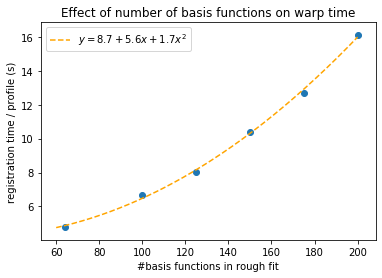

In [1277]:
xs = np.array([64, 100, 125, 150, 175, 200])
ys = np.array([4.79, 6.7, 8.03, 10.4, 12.7, 16.1])
plt.xlabel('#basis functions in rough fit');
plt.ylabel('registration time / profile (s)');
polyfit = np.polynomial.Polynomial.fit(xs, ys, deg=2)
coefs = polyfit.coef
xdense = np.linspace(60,200,200)
plt.plot(xdense, polyfit(xdense), color='orange', linestyle='--', 
         label=rf'$y={coefs[0]:.1f} + {coefs[1]:.1f}x + {coefs[2]:.1f}x^2$')
plt.scatter(xs, ys)
plt.gca().set_title('Effect of number of basis functions on warp time');
plt.legend();
plt.savefig('/Users/sean/Desktop/time_per_basis.pdf')


In [1075]:
(untrimmed_i.sel(wavelength='410', pair=0) / untrimmed_i.sel(wavelength='470', pair=0)).T

<xarray.DataArray (position: 200)>
array([1.206897, 1.202985, 1.196023, 1.189702, 1.183246, 1.182741, 1.179361,
       1.194313, 1.211009, 1.22807 , 1.259398, 1.281713, 1.308886, 1.39156 ,
       1.43609 , 1.459459, 1.44897 , 1.442485, 1.434198, 1.413161, 1.396122,
       1.385314, 1.390423, 1.395401, 1.397735, 1.395785, 1.394119, 1.393103,
       1.393496, 1.39353 , 1.394182, 1.395213, 1.396056, 1.394417, 1.387941,
       1.382593, 1.377668, 1.373192, 1.368953, 1.365729, 1.363885, 1.362017,
       1.362364, 1.365764, 1.369335, 1.372209, 1.372734, 1.373059, 1.37149 ,
       1.368089, 1.364564, 1.362373, 1.361301, 1.359987, 1.357958, 1.354786,
       1.351852, 1.353353, 1.358287, 1.363327, 1.366323, 1.367393, 1.368238,
       1.367382, 1.365628, 1.364144, 1.366134, 1.370364, 1.374439, 1.379699,
       1.385366, 1.391162, 1.387498, 1.380764, 1.374876, 1.36891 , 1.363126,
       1.357683, 1.354755, 1.352585, 1.350223, 1.347636, 1.344837, 1.341956,
       1.342314, 1.343653, 1.344872, 1.34

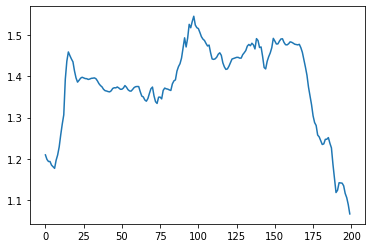

In [1086]:
plt.plot(np.squeeze(reg_data.r410[0].data_matrix) / np.squeeze(reg_data.r470[0].data_matrix)  )

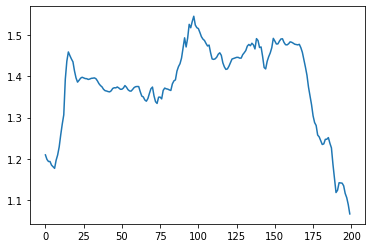

In [1094]:
plt.plot(np.squeeze((reg_data.r410[0] / reg_data.r470[0]).data_matrix))

In [1103]:
untrimmed_i.sel(wavelength='410', pair=0)

<xarray.DataArray (position: 200)>
array([  385.,   403.,   421.,   439.,   452.,   466.,   480.,   504.,   528.,
         560.,   670.,   778.,   928.,  1418.,  1910.,  2430.,  3095.,  3762.,
        4370.,  4703.,  5040.,  5339.,  5488.,  5643.,  5802.,  5960.,  6116.,
        6262.,  6385.,  6505.,  6614.,  6704.,  6796.,  6894.,  6998.,  7101.,
        7230.,  7407.,  7584.,  7771.,  7976.,  8183.,  8369.,  8521.,  8672.,
        8789.,  8861.,  8929.,  8938.,  8883.,  8826.,  8726.,  8583.,  8436.,
        8327.,  8252.,  8176.,  8112.,  8056.,  8000.,  7952.,  7909.,  7866.,
        7898.,  7978.,  8058.,  8205.,  8388.,  8571.,  8699.,  8804.,  8909.,
        9145.,  9432.,  9719.,  9863.,  9959., 10055.,  9971.,  9836.,  9700.,
        9548.,  9391.,  9234.,  8968.,  8680.,  8392.,  8002.,  7596.,  7190.,
        6806.,  6424.,  6041.,  5878.,  5732.,  5587.,  5520.,  5457.,  5394.,
        5404.,  5415.,  5426.,  5439.,  5452.,  5465.,  5460.,  5455.,  5447.,
        5368.,  5

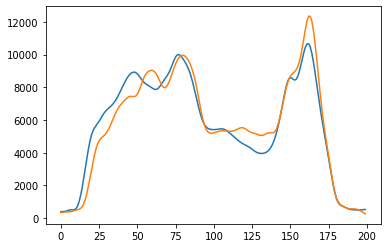

In [1282]:
plt.plot(reg_data.reg_data.sel(wavelength='410', pair=0).values.T)

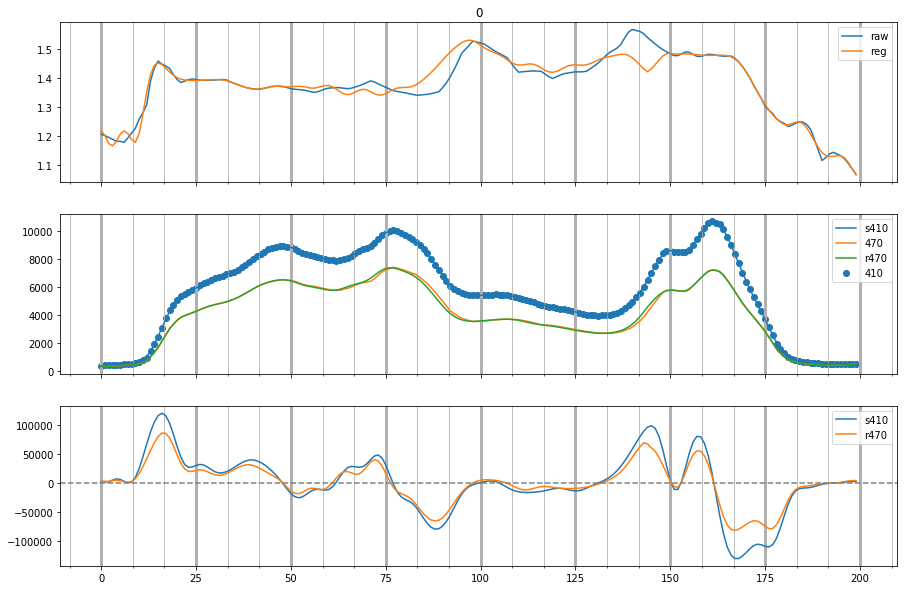

In [1276]:
reload(profile_processing);
i = i + 1
untrimmed_i = ex.untrimmed_profiles[:2]
reg_data = profile_processing.register_profiles(untrimmed_i, warp_lam=1e-1, rough_lambda=1e-7, rough_nbasis=50)

fig, axes = plt.subplots(3,1,figsize=(15,10), sharex='all')
ax = axes[0]
# i = (i + 1) % len(reg_data.r470[0])
i = 0
ax.plot((untrimmed_i.sel(wavelength='410', pair=0) / untrimmed_i.sel(wavelength='470', pair=0))[i].T, label='raw')
xs = np.linspace(0,1,200)
ax.plot(np.squeeze((reg_data.r410[0][i] / reg_data.r470[0][i])(xs)),label='reg')
ax.set_title(i);
ax.legend();
ax.grid(True, which='major', axis='x', linewidth=3);
ax.grid(True, which='minor', axis='x');
ax.xaxis.set_minor_locator(AutoMinorLocator(3));

ax = axes[1]
ax.scatter(np.arange(200), untrimmed_i.sel(wavelength='410', pair=0)[i], label='410')
ax.plot(np.squeeze(reg_data.r410[0][i](xs)), label='s410')
ax.plot(untrimmed_i.sel(wavelength='470', pair=0)[i], label='470')
ax.plot(np.squeeze(reg_data.r470[0][i](xs)), label='r470')
ax.legend();
ax.grid(True, which='major', axis='x', linewidth=3);
ax.grid(True, which='minor', axis='x');
ax.xaxis.set_minor_locator(AutoMinorLocator(3));

ax = axes[2]
ax.plot(np.squeeze(reg_data.r410[0][i].derivative()(xs)), label='s410');
ax.plot(np.squeeze(reg_data.r470[0][i].derivative()(xs)), label='r470');
ax.axhline(0, linestyle='--', color='gray')
ax.legend();
ax.grid(True, which='major', axis='x', linewidth=3);
ax.grid(True, which='minor', axis='x');
ax.xaxis.set_minor_locator(AutoMinorLocator(3));

In [1160]:
untrimmed_i = ex.untrimmed_profiles

In [1273]:
i = (i + 1) % untrimmed_i.shape[0]
xs = np.linspace(0,1,400)
with PdfPages('/Users/sean/Desktop/test.pdf') as pdf:
    for i in tqdm_notebook(range(untrimmed_i.shape[0])):
        plt.figure(figsize=(15,10))
        ys_raw = untrimmed_i[i,0,0]
        xs = np.linspace(0,1,200)
        plt.scatter(xs, ys_raw, s=10, color='C7')
        for nb in [50,65]:
            for sm in np.power(10., np.array([-7])):
                ys = np.squeeze(profile_processing.smooth_profile_data(ys_raw, order=6, smoothing_parameter=sm, nbasis=nb)[0](xs))
                plt.plot(
                    xs,
                    ys,
                    label=fr'$\lambda={sm:.2}$ nb={nb}'
                )
        plt.legend()
        plt.gca().set_title(i)
        pdf.savefig()
        plt.close()

In [136]:
regions = {
    'pm3': [.07, .28],
    'pm4': [.33, .45],
    'pm5': [.53, .70],
    'pm6': [.80, .86],
    'pm7': [.88, .96],
}

prof_len = ex.untrimmed_profiles.shape[-1]
scaled_regions = {
    region: (prof_len * np.asarray(regions[region])).astype(np.int)
    for region in regions.keys()
}

In [21]:
ex.summary_table['total'] = ex.summary_table['anterior'] + ex.summary_table['posterior'] + ex.summary_table['sides_of_tip'] + ex.summary_table['tip']

non_movers = ex.summary_table[(ex.summary_table.pair==0) & (ex.summary_table.total == 0)].animal.unique()

non_moving_profiles = ex.untrimmed_profiles[non_movers]

In [211]:
min_shift = 0
max_shift = 10
n_steps = 10

raw_shifts = []
reg_shifts = []
shifts = np.linspace(max_shift,min_shift,n_steps)

for i in tqdm_notebook(shifts):
    shifted_profiles = non_moving_profiles.copy()
    shifted_profiles.loc[dict(pair=0, wavelength='470')] = ndi.interpolation.shift(
        non_moving_profiles.sel(wavelength='470', pair=0),
        (0, i),
        order=1,
        mode='nearest'
    )

    reg_profiles = profile_processing.register_profiles(shifted_profiles, warp_lam=.1)
    
    raw_shifts.append(shifted_profiles)
    reg_shifts.append(reg_profiles)

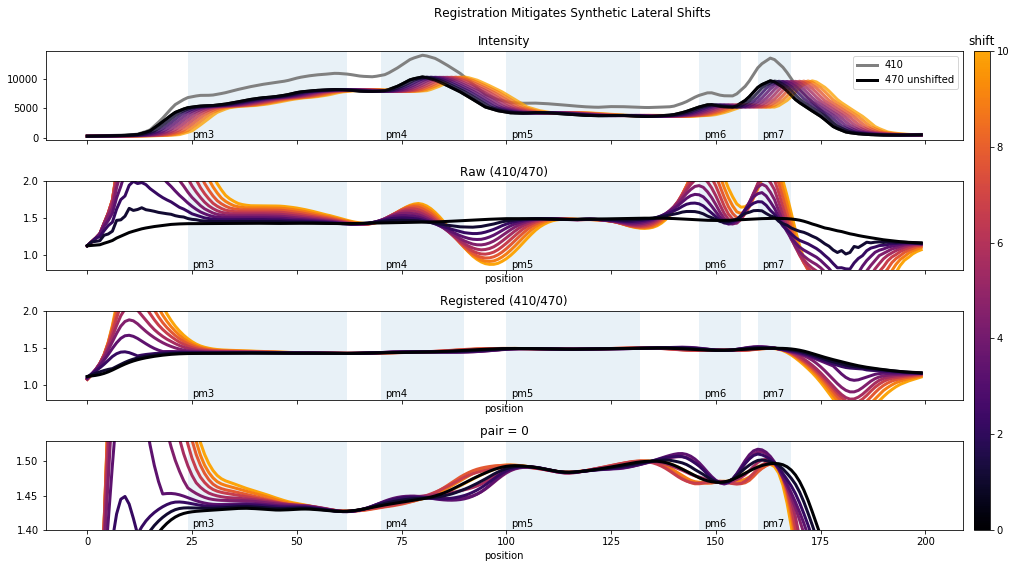

In [232]:
# plot
norm = mpl.colors.Normalize(vmin=min_shift, vmax=max_shift)
cmap = cm.inferno
newcmp = ListedColormap(cm.inferno(np.linspace(0, 0.8, 256)))
m = cm.ScalarMappable(norm=norm, cmap=newcmp)
fig, axes = plt.subplots(4,1,figsize=(16,8), sharex='all')
axes[0].plot(raw_shifts[-1].sel(wavelength='410', pair=0)[0].values, linewidth=3, label='410', color='gray')
axes[0].plot(raw_shifts[-1].sel(wavelength='470', pair=0)[0].values, color=m.to_rgba(shifts[-1]), linewidth=3, label='470 unshifted')
for i in range(len(c)):
    axes[0].plot(raw_shifts[i].sel(wavelength='470', pair=0)[0].values, color=m.to_rgba(shifts[i]), linewidth=3, alpha=0.8)
    (
        non_moving_profiles.sel(wavelength='410', pair=0).mean(dim='strain') /
        raw_shifts[i].sel(wavelength='470', pair=0).mean(dim='strain')
    ).plot(color=m.to_rgba(shifts[i]), label=f'shift={shifts[i]}', linewidth=3, ax = axes[1])
    
    (
        reg_shifts[i].sel(wavelength='410', pair=0).mean(dim='strain') /
        reg_shifts[i].sel(wavelength='470', pair=0).mean(dim='strain')
    ).plot(color=m.to_rgba(shifts[i]), label=f'shift={shifts[i]}', linewidth=3, ax = axes[2])
    
    (
        reg_shifts[i].sel(wavelength='410', pair=0).mean(dim='strain') /
        reg_shifts[i].sel(wavelength='470', pair=0).mean(dim='strain')
    ).plot(color=m.to_rgba(shifts[i]), label=f'shift={shifts[i]}', linewidth=3, ax = axes[3])

regions = {
    'pm3': [.12, .31],
    'pm4': [.35, .45],
    'pm5': [.50, .66],
    'pm6': [.73, .78],
    'pm7': [.80, .84],
}

prof_len = 200
scaled_regions = {
    region: (prof_len * np.asarray(regions[region])).astype(np.int)
    for region in regions.keys()
}
plt.suptitle('Registration Mitigates Synthetic Lateral Shifts')
axes[0].set_title('Intensity')
axes[0].legend()
axes[1].set_ylim(.8,2)
axes[2].set_ylim(.8,2)
axes[3].set_ylim(1.4,1.53)
axes[1].set_title('Raw (410/470)')
axes[2].set_title('Registered (410/470)')

fig.tight_layout(rect=[0, 0, 1, 0.95])
axcb = fig.colorbar(m, ax=axes.ravel().tolist(), pad=0.01, aspect = 30)
axcb.ax.set_title('shift');
plots.add_regions_to_axis(axes[0], scaled_regions)
plots.add_regions_to_axis(axes[1], scaled_regions)
plots.add_regions_to_axis(axes[2], scaled_regions)
plots.add_regions_to_axis(axes[3], scaled_regions)


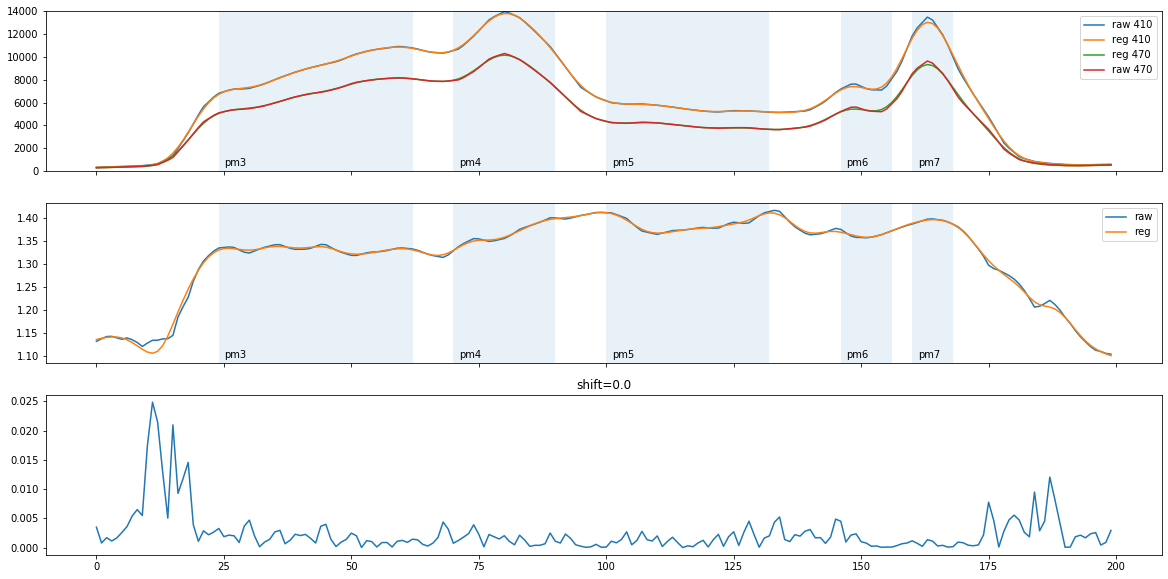

In [274]:
i = 9
fig, axes = plt.subplots(3,1, figsize=(20,10), sharex='all')
ax = axes[0]
ax.plot(raw_shifts[i].sel(wavelength='410', pair=0)[0], label='raw 410')
ax.plot(reg_shifts[i].sel(wavelength='410', pair=0)[0], label='reg 410')
ax.plot(reg_shifts[i].sel(wavelength='470', pair=0)[0], label='reg 470')
ax.plot(raw_shifts[i].sel(wavelength='470', pair=0)[0], label='raw 470')
ax.set_ylim(0,14000)
plots.add_regions_to_axis(ax, scaled_regions)
ax.legend()

plt.gca().set_title(f'shift={shifts[i]}')
ax = axes[1]
raw_r = raw_shifts[i].sel(wavelength='410', pair=0)[0] / raw_shifts[i].sel(wavelength='470', pair=0)[0]
ax.plot(raw_r, label='raw')

reg_r =reg_shifts[i].sel(wavelength='410', pair=0)[0] / reg_shifts[i].sel(wavelength='470', pair=0)[0]
ax.plot(reg_r, label='reg')
ax.legend()
plots.add_regions_to_axis(ax, scaled_regions)

ax = axes[2]
ax.plot(np.abs(1 - (reg_r/raw_r)))

In [285]:
i410, _ = profile_processing.smooth_profile_data(raw_shifts[0][0].sel(wavelength='410', pair=0))
i470, _ = profile_processing.smooth_profile_data(raw_shifts[0][0].sel(wavelength='470', pair=0))

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x136c50a20>])

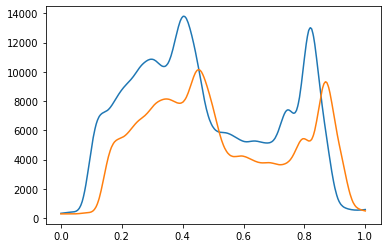

In [287]:
i410.plot()
i470.plot()

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x1331a08d0>])

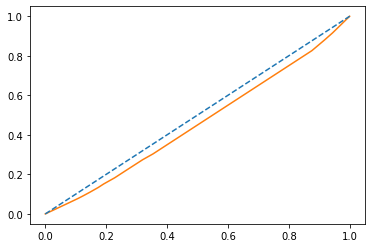

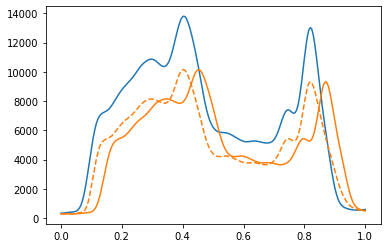

In [301]:
import skfda
from skfda.preprocessing.registration import elastic_registration_warping
warping = elastic_registration_warping(i410, i470, lam=.1)

plt.figure()

# Warping used
warping.plot(color='C1')
t = np.linspace(0, 1)
plt.plot(t, t, linestyle='--', color='C0')
plt.figure()
i410.plot(label='$i410$')
warping_inverse = skfda.preprocessing.registration.invert_warping(warping)
i470.plot(color='C1')
i470.compose(warping_inverse).plot(color='C1', linestyle='--')

In [610]:
import scipy

scipy.integrate.simps(np.squeeze(warping.data_matrix))

91.19062574778656

In [621]:
import scipy
t = np.linspace(0,1,200)
scipy.integrate.simps(y=t, x=t) - scipy.integrate.simps(y=np.squeeze(warping.data_matrix), x=t)

0.041755649508610215

In [649]:
i410 = non_moving_profiles.sel(wavelength='410', pair=0)
i470 = non_moving_profiles.sel(wavelength='470', pair=0)

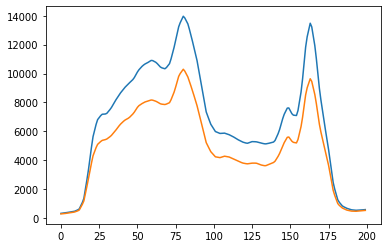

In [650]:
i470_s = ndi.interpolation.shift(i470, 0, order=1, mode='nearest')
plt.plot(i410[0])
plt.plot(i470_s[0])

In [723]:
shifts = np.linspace(0, 10, 20)
dists = []
i410_,_ = profile_processing.smooth_profile_data(i410)
i470_,_ = profile_processing.smooth_profile_data(i470)
t = np.linspace(0,1,200)
t_int = scipy.integrate.simps(y=t, x=t)
for shift in tqdm_notebook(shifts):
    i470_s,_ = profile_processing.smooth_profile_data(ndi.interpolation.shift(np.squeeze(i470_.data_matrix), shift, order=1, mode='nearest'))
    w = skfda.preprocessing.registration.elastic_registration_warping(i410_, i470_s)
    area_bw_warp = t_int - scipy.integrate.simps(y=np.squeeze(w.data_matrix), x=t)
    dists.append((shift, area_bw_warp))
#     for i in range(non_moving_profiles.strain.size):
#         i410_ = skfda.FDataGrid(np.pad(i410[i], 15, mode='edge'))
#         i470_ = skfda.FDataGrid(np.pad(i470[i], 15, mode='edge'))
#         i470_s = skfda.FDataGrid(ndi.interpolation.shift(np.squeeze(i470_.data_matrix), shift, order=1, mode='nearest'))
        
#         dists.append((shift, skfda.misc.metrics.phase_distance(i410_, i470_s)))

In [724]:
ds = np.concatenate([d[1] for d in dists])

In [725]:
ss = np.repeat([d[0] for d in dists], len(i410_))

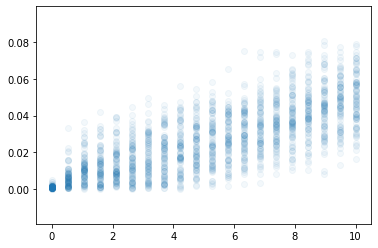

In [749]:
plt.scatter(ss, np.abs(ds), alpha=0.05)

Text(0.5, 1.0, 'hello')

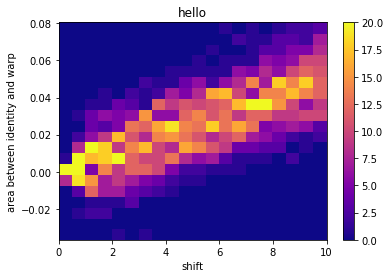

In [753]:
plt.hist2d(ss, ds, bins=(20, 20),
           cmap=plt.cm.plasma, vmin=0, vmax=20);
plt.colorbar();
plt.xlabel('shift');
plt.ylabel('area between identity and warp');
plt.gca().set_title('hello')

In [413]:
i410_ = np.pad(np.squeeze(i410.data_matrix), 50, mode='edge')
i410s = ndi.interpolation.shift(i410_, .6, order=1, mode='nearest')

shifts = np.linspace(0, 20, 100)
ds = []
for s in shifts:
    i410s = ndi.interpolation.shift(i410_, s, order=1, mode='nearest')
    ds.append(skfda.misc.metrics.phase_distance(skfda.FDataGrid(i410_), skfda.FDataGrid(i410s)))

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x14465ca90>])

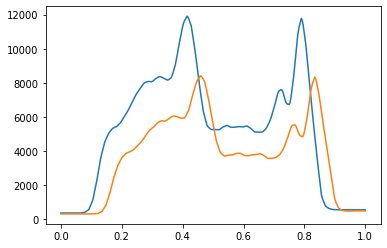

In [602]:
i410_[0].plot()
i470_s[0].plot()